The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


# Concise Implementation of Linear Regression
:label:`sec_linear_concise`

Deep learning has witnessed a sort of Cambrian explosion
over the past decade.
The sheer number of techniques, applications and algorithms by far surpasses the
progress of previous decades.
This is due to a fortuitous combination of multiple factors,
one of which is the powerful free tools
offered by a number of open-source deep learning frameworks.
Theano :cite:`Bergstra.Breuleux.Bastien.ea.2010`,
DistBelief :cite:`Dean.Corrado.Monga.ea.2012`,
and Caffe :cite:`Jia.Shelhamer.Donahue.ea.2014`
arguably represent the
first generation of such models
that found widespread adoption.
In contrast to earlier (seminal) works like
SN2 (Simulateur Neuristique) :cite:`Bottou.Le-Cun.1988`,
which provided a Lisp-like programming experience,
modern frameworks offer automatic differentiation
and the convenience of Python.
These frameworks allow us to automate and modularize
the repetitive work of implementing gradient-based learning algorithms.

In :numref:`sec_linear_scratch`, we relied only on
(i) tensors for data storage and linear algebra;
and (ii) automatic differentiation for calculating gradients.
In practice, because data iterators, loss functions, optimizers,
and neural network layers
are so common, modern libraries implement these components for us as well.
In this section, (**we will show you how to implement
the linear regression model**) from :numref:`sec_linear_scratch`
(**concisely by using high-level APIs**) of deep learning frameworks.


In [2]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## Defining the Model

When we implemented linear regression from scratch
in :numref:`sec_linear_scratch`,
we defined our model parameters explicitly
and coded up the calculations to produce output
using basic linear algebra operations.
You *should* know how to do this.
But once your models get more complex,
and once you have to do this nearly every day,
you will be glad of the assistance.
The situation is similar to coding up your own blog from scratch.
Doing it once or twice is rewarding and instructive,
but you would be a lousy web developer
if you spent a month reinventing the wheel.

For standard operations,
we can [**use a framework's predefined layers,**]
which allow us to focus
on the layers used to construct the model
rather than worrying about their implementation.
Recall the architecture of a single-layer network
as described in :numref:`fig_single_neuron`.
The layer is called *fully connected*,
since each of its inputs is connected
to each of its outputs
by means of a matrix--vector multiplication.


In PyTorch, the fully connected layer is defined in `Linear` and `LazyLinear` classes (available since version 1.8.0).
The latter
allows users to specify *merely*
the output dimension,
while the former
additionally asks for
how many inputs go into this layer.
Specifying input shapes is inconvenient and may require nontrivial calculations
(such as in convolutional layers).
Thus, for simplicity, we will use such "lazy" layers
whenever we can.


In [3]:
class LinearRegression(d2l.Module):
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In the `forward` method we just invoke the built-in `__call__` method of the predefined layers to compute the outputs.


In [4]:
@d2l.add_to_class(LinearRegression)
def forward(self, X):
    return self.net(X)

## Defining the Loss Function


[**The `MSELoss` class computes the mean squared error (without the $1/2$ factor in :eqref:`eq_mse`).**]
By default, `MSELoss` returns the average loss over examples.
It is faster (and easier to use) than implementing our own.


In [5]:
@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

## Defining the Optimization Algorithm


Minibatch SGD is a standard tool
for optimizing neural networks
and thus PyTorch supports it alongside a number of
variations on this algorithm in the `optim` module.
When we (**instantiate an `SGD` instance,**)
we specify the parameters to optimize over,
obtainable from our model via `self.parameters()`,
and the learning rate (`self.lr`)
required by our optimization algorithm.


In [6]:
@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

## Training

You might have noticed that expressing our model through
high-level APIs of a deep learning framework
requires fewer lines of code.
We did not have to allocate parameters individually,
define our loss function, or implement minibatch SGD.
Once we start working with much more complex models,
the advantages of the high-level API will grow considerably.

Now that we have all the basic pieces in place,
[**the training loop itself is the same
as the one we implemented from scratch.**]
So we just call the `fit` method (introduced in :numref:`oo-design-training`),
which relies on the implementation of the `fit_epoch` method
in :numref:`sec_linear_scratch`,
to train our model.


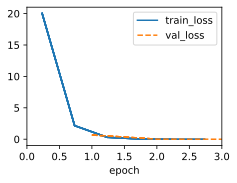

In [7]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Below, we
[**compare the model parameters learned
by training on finite data
and the actual parameters**]
that generated our dataset.
To access parameters,
we access the weights and bias
of the layer that we need.
As in our implementation from scratch,
note that our estimated parameters
are close to their true counterparts.


In [8]:
@d2l.add_to_class(LinearRegression)
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

In [9]:
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0053, -0.0030])
error in estimating b: tensor([0.0128])


## Summary

This section contains the first
implementation of a deep network (in this book)
to tap into the conveniences afforded
by modern deep learning frameworks,
such as MXNet :cite:`Chen.Li.Li.ea.2015`,
JAX :cite:`Frostig.Johnson.Leary.2018`,
PyTorch :cite:`Paszke.Gross.Massa.ea.2019`,
and Tensorflow :cite:`Abadi.Barham.Chen.ea.2016`.
We used framework defaults for loading data, defining a layer,
a loss function, an optimizer and a training loop.
Whenever the framework provides all necessary features,
it is generally a good idea to use them,
since the library implementations of these components
tend to be heavily optimized for performance
and properly tested for reliability.
At the same time, try not to forget
that these modules *can* be implemented directly.
This is especially important for aspiring researchers
who wish to live on the leading edge of model development,
where you will be inventing new components
that cannot possibly exist in any current library.


In PyTorch, the `data` module provides tools for data processing,
the `nn` module defines a large number of neural network layers and common loss functions.
We can initialize the parameters by replacing their values
with methods ending with `_`.
Note that we need to specify the input dimensions of the network.
While this is trivial for now, it can have significant knock-on effects
when we want to design complex networks with many layers.
Careful considerations of how to parametrize these networks
is needed to allow portability.


## Exercises

1. How would you need to change the learning rate if you replace the aggregate loss over the minibatch
   with an average over the loss on the minibatch?
1. Review the framework documentation to see which loss functions are provided. In particular,
   replace the squared loss with Huber's robust loss function. That is, use the loss function
   $$l(y,y') = \begin{cases}|y-y'| -\frac{\sigma}{2} & \textrm{ if } |y-y'| > \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \textrm{ otherwise}\end{cases}$$
1. How do you access the gradient of the weights of the model?
1. What is the effect on the solution if you change the learning rate and the number of epochs? Does it keep on improving?
1. How does the solution change as you vary the amount of data generated?
    1. Plot the estimation error for $\hat{\mathbf{w}} - \mathbf{w}$ and $\hat{b} - b$ as a function of the amount of data. Hint: increase the amount of data logarithmically rather than linearly, i.e., 5, 10, 20, 50, ..., 10,000 rather than 1000, 2000, ..., 10,000.
    2. Why is the suggestion in the hint appropriate?


[Discussions](https://discuss.d2l.ai/t/45)


1. 更换损失计算方式后学习率的调整
解析：当把小批量数据的聚合损失（通常是求和）替换为小批量数据损失的平均值时，损失值的量级发生了变化。假设原来聚合损失是将小批量中每个样本的损失相加，现在变为求平均。由于平均值相比求和值变小（小批量样本数大于 1 时），梯度也会相应变小（因为梯度与损失值相关）。为了使模型更新幅度与原来大致相当，通常需要将学习率乘以小批量的样本数，以补偿损失值变小带来的影响，让模型在参数更新上保持合适的步长。

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# 生成模拟数据
x = torch.randn(64, 10)  # 批量大小=64
y = torch.randint(0, 5, (64,))

# 定义模型
model = nn.Linear(10, 5)

# 方案1：使用聚合损失（求和），学习率=0.01
optimizer_sum = optim.SGD(model.parameters(), lr=0.01)
criterion_sum = nn.CrossEntropyLoss(reduction='sum')  # 求和聚合

# 方案2：使用平均损失，学习率=0.01*64（批量大小）
optimizer_mean = optim.SGD(model.parameters(), lr=0.01 * 64)
criterion_mean = nn.CrossEntropyLoss(reduction='mean')  # 平均聚合

# 模拟单步训练（仅展示学习率调整逻辑）
def train_step(optimizer, criterion):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 验证两种方案的梯度量级
loss_sum = train_step(optimizer_sum, criterion_sum)
loss_mean = train_step(optimizer_mean, criterion_mean)

print(f"Sum Loss: {loss_sum:.4f} | Mean Loss: {loss_mean:.4f}")
print(f"学习率调整比例: {optimizer_mean.param_groups[0]['lr'] / optimizer_sum.param_groups[0]['lr']}")

Sum Loss: 110.1507 | Mean Loss: 1.5865
学习率调整比例: 64.0


2. 用 Huber 鲁棒损失函数替换平方损失函数


In [10]:
import torch
import torch.nn as nn

# 假设模型输出y_hat和真实标签y
y_hat = torch.tensor([1.2, 2.5, 3.7])
y = torch.tensor([1.0, 2.0, 4.0])
sigma = 1.0  # Huber损失的超参数

# 定义Huber损失函数
def huber_loss(y_hat, y, sigma):
    diff = torch.abs(y_hat - y)
    cond = diff > sigma
    loss = torch.where(cond, diff - 0.5 * sigma, 0.5 * (diff ** 2) / sigma)
    return torch.mean(loss)

huber_loss_value = huber_loss(y_hat, y, sigma)
print(huber_loss_value)

tensor(0.0633)


3. 访问模型权重的梯度


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义简单模型
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        return self.fc2(self.fc1(x))

model = SimpleModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 模拟训练步骤
x = torch.randn(32, 10)
y = torch.randint(0, 2, (32,))

# 前向传播
output = model(x)
loss = criterion(output, y)

# 反向传播计算梯度
optimizer.zero_grad()
loss.backward()

# 访问权重梯度
print("第一层权重梯度形状:", model.fc1.weight.grad.shape)
print("第二层偏置梯度:", model.fc2.bias.grad)

# 梯度范数（衡量梯度大小）
grad_norm = torch.norm(model.fc1.weight.grad)
print(f"第一层权重梯度范数: {grad_norm:.4f}")

第一层权重梯度形状: torch.Size([5, 10])
第二层偏置梯度: tensor([ 0.2281, -0.2281])
第一层权重梯度范数: 0.2659


4. 改变学习率和训练轮数对结果的影响


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

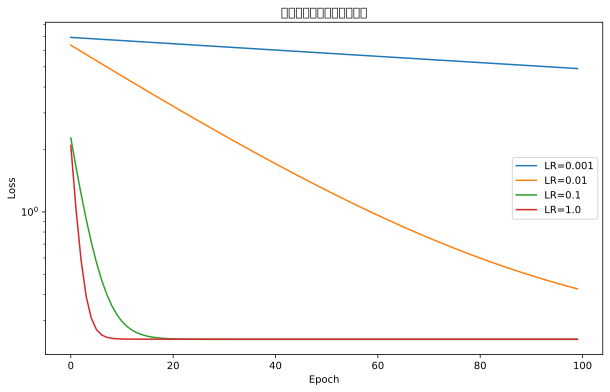

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 生成简单线性回归数据
x = torch.randn(100, 1)
y = 2 * x + 1 + 0.5 * torch.randn(100, 1)

# 定义模型
model = nn.Linear(1, 1)

# 不同学习率的实验
learning_rates = [0.001, 0.01, 0.1, 1.0]
results = {}

for lr in learning_rates:
    # 重置模型参数
    model.reset_parameters()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    # 训练100个epoch
    for epoch in range(100):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    results[lr] = losses

# 绘制学习曲线
plt.figure(figsize=(10, 6))
for lr, losses in results.items():
    plt.plot(losses, label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('不同学习率的收敛速度对比')
plt.legend()
plt.yscale('log')  # 使用对数刻度更清晰地观察差异
plt.show()

5. 数据量变化对结果的影响


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

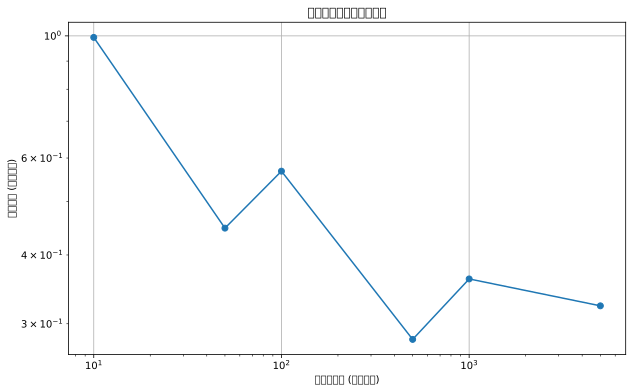

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 生成数据函数
def generate_data(n_samples, noise=0.5):
    x = torch.randn(n_samples, 1)
    y = 2 * x + 1 + noise * torch.randn(n_samples, 1)
    return x, y

# 定义模型
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# 不同数据量的实验
data_sizes = [10, 50, 100, 500, 1000, 5000]
test_errors = []

# 固定测试集
x_test, y_test = generate_data(1000, noise=0.5)

for size in data_sizes:
    # 生成训练集
    x_train, y_train = generate_data(size, noise=0.5)

    # 初始化模型
    model = LinearRegression()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # 训练模型
    for epoch in range(100):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # 在测试集上评估
    with torch.no_grad():
        y_pred_test = model(x_test)
        test_error = criterion(y_pred_test, y_test).item()
        test_errors.append(test_error)

# 绘制误差与数据量的关系
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, test_errors, 'o-')
plt.xscale('log')  # 使用对数坐标更清晰地展示关系
plt.yscale('log')
plt.xlabel('训练数据量 (对数刻度)')
plt.ylabel('测试误差 (对数刻度)')
plt.title('模型误差与数据量的关系')
plt.grid(True)
plt.show()